[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239417-lesson-7-agent-with-memory)

# Agent memory

## 復習

以前、私たちは次のような機能を持つエージェントを構築しました。

* `act` - モデルが特定のツールを呼び出す
* `observe` - ツールの出力結果をモデルに返す
* `reason` - モデルがツールの出力結果について推論し、次に何をすべきかを決定する(例えば、別のツールを呼び出すか、直接応答するかを決定する)


![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)


## Goals
次に、メモリを導入してエージェントを拡張します。




In [2]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [1]:
import os
import getpass

def _set_env(var: str) -> None:
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

[LangSmith](https://docs.smith.langchain.com/)を[処理の追跡(tracing)](https://docs.smith.langchain.com/concepts/tracing)に使います。


In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

以下、agent.ipynbでに行ったことと同様です。　

In [2]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o-2024-08-06")
llm_with_tools = llm.bind_tools(tools)

In [3]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState) -> dict[str, list]:
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

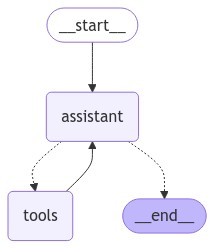

In [4]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Memory

先ほど(agent.ipynb)と同じようにエージェントを動かしてみましょう。



In [5]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_CYTcHlxnffzKoA61UP147xto)
 Call ID: call_CYTcHlxnffzKoA61UP147xto
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


ここで、2を乗算してみましょう。

In [6]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

It seems like there is a missing piece of information. Could you please specify what number you would like to multiply by 2?


私たちは最初のチャットから7の記憶(memory)を保持していません！

これは、1回のグラフの実行に対して [state が一時的](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) だからです。

もちろん、これでは複数ターンの会話を中断して行うことはできません。

[永続性(persistace)](https://langchain-ai.github.io/langgraph/how-tos/persistence/)を使ってこの問題に対処することができます！

LangGraphはチェックポインタ(checkpointer)を使い、各ステップの後にグラフの状態を自動的に保存します。

このビルトイン永続化レイヤは、LangGraphが最後に状態を更新したときから、その状態をピックアップできるように、記憶(momory)を与えてくれます。

最も簡単に使えるチェックポインタの一つは `MemorySaver` で、これはグラフの状態を保存するin-memoryのキー・バリュー・ストアです。

チェックポインタでグラフをコンパイルするだけで、グラフは記憶(memory)を持ちます！


In [7]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

記憶(memory)を使用する場合、`thread_id` を指定する必要があります。

この `thread_id` はグラフの状態のコレクションを保存します。

以下はポンチ絵です：

* チェックポインタはグラフのすべてのステップの状態を書き込みます
* これらのチェックポイントはスレッドに保存されます
* 将来、`thread_id`を使ってそのスレッドにアクセスできます


![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)



In [8]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_HAzAf2sbckPunFsNhOp5U6UT)
 Call ID: call_HAzAf2sbckPunFsNhOp5U6UT
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.



同じ `thread_id` を渡すと、以前に同じ `thread_id` でログに記録された状態のチェックポイントから処理を進めることができます！

この場合、上記の会話がスレッドに取り込まれます。

`HumanMessage(content="multiply that by 2.")` は上記の会話に追加されます。

つまり、モデルは `that` が `"Add 3 and 4" の結果`　であると知ります。


In [9]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_HAzAf2sbckPunFsNhOp5U6UT)
 Call ID: call_HAzAf2sbckPunFsNhOp5U6UT
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_rkRPQTng3SKzY4D51HctPm1C)
 Call ID: call_rkRPQTng3SKzY4D51HctPm1C
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result 

## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Load the `agent` in the UI, which uses `module-1/studio/agent.py` set in `module-1/studio/langgraph.json`.